# Projet n°2

## 1) Développement d'un jeu

In [5]:
import numpy as np
space=np.zeros((4,4))

space[1,0]=-1
space[1,2]=-1
space[2,3]=-1
space[3,1]=-1
space[3,3]=1

print(space)

[[ 0.  0.  0.  0.]
 [-1.  0. -1.  0.]
 [ 0.  0.  0. -1.]
 [ 0. -1.  0.  1.]]


In [6]:

position_initiale = [0, 0] 

def application_action(action, position, space):
    if action == 0:  # Haut
        nouvelle_position = [max(position[0] - 1, 0), position[1]]
    elif action == 1:  # Droite
        nouvelle_position = [position[0], min(position[1] + 1, len(space[0]) - 1)]
    elif action == 2:  # Bas
        nouvelle_position = [min(position[0] + 1, len(space) - 1), position[1]]
    elif action == 3:  # Gauche
        nouvelle_position = [position[0], max(position[1] - 1, 0)]
    else:
        nouvelle_position = position  # Si l'action est invalide, on ne bouge pas

    # Récupérer l'élément de la case où l'agent s'est déplacé
    reward = space[nouvelle_position[0]][nouvelle_position[1]]

    # Calculer la récompense et déterminer si la partie est finie
    if reward == -1:
        nouvelle_position = [0, 0] 
        fin = False
    elif reward == 0:
        fin = False
    elif reward == 1:
        fin = True


    return nouvelle_position, reward, fin


# Test de la fonction avec quelques exemples
position_actuelle = [0, 0]  # Position initiale de l'agent
action = 2  # L'agent va à droite (action 1)

nouvelle_position, reward, fin = application_action(action, position_actuelle, space)
print(f"Nouvelle position: {nouvelle_position}, Récompense: {reward}, Fin de partie: {fin}")

Nouvelle position: [0, 0], Récompense: -1.0, Fin de partie: False


## Développement du Q-learning

In [ ]:
import numpy as np
import random

# Configuration des paramètres
alpha = 0.81  # Taux d'apprentissage
gamma = 0.96  # Facteur de discount

# Initialisation de la table Q avec 16 états (cases) et 4 actions
q_table = np.zeros((16, 4))  # Dimensions : [cases x actions]

# Espace et récompenses
space = np.zeros((4, 4))
space[1, 0] = -1
space[1, 2] = -1
space[2, 3] = -1
space[3, 1] = -1
space[3, 3] = 1

# Fonction pour convertir une position (ligne, colonne) en un indice unique de 0 à 15
def position_to_index(position):
    return position[0] * 4 + position[1]

# Fonction pour choisir une action avec la stratégie epsilon-greedy
def choose_action(state_index, epsilon, q_table):
    if random.uniform(0, 1) < epsilon:
        # Exploration : choisir une action aléatoire
        action = random.choice([0, 1, 2, 3])  # Actions possibles : Haut, Droite, Bas, Gauche
        exploration = True
    else:
        # Exploitation : choisir l'action avec la plus grande valeur Q
        action = np.argmax(q_table[state_index, :])
        exploration = False
    return action, exploration

# Fonction d'une itération de Q-learning
def onestep(q_table, state, epsilon, exploration_counts):
    state_index = position_to_index(state)  # Convertir la position en indice
    action, exploration = choose_action(state_index, epsilon, q_table)  # Choisir une action

        # Mettre à jour les compteurs d'exploration/exploitation
    if exploration:
        exploration_counts["random"][-1] += 1
    else:
        exploration_counts["q_table"][-1] += 1

    # Appliquer l'action et obtenir la nouvelle position, la récompense et si la partie est finie
    nouvelle_position, reward, fin = application_action(action, state, space)
    nouvelle_position_index = position_to_index(nouvelle_position)

    # Mettre à jour la valeur Q
    old_value = q_table[state_index, action]
    next_max = np.max(q_table[nouvelle_position_index, :])
    q_table[state_index, action] = old_value + alpha * (reward + gamma * next_max - old_value)
    
    
    return q_table, nouvelle_position, fin,reward

# Entraînement de l'agent avec plusieurs épisodes
num_episodes = 5000
epsilon_values = [] 
exploration_counts = {"random": [], "q_table": []}

cumulative_random = 0
cumulative_q_table = 0
rewards_per_episode=[]
step_per_episode=[]
for episode in range(num_episodes):
    epsilon = num_episodes / (num_episodes + episode)
    epsilon_values.append(epsilon)

    # Ajouter des compteurs pour cet épisode
    exploration_counts["random"].append(0)
    exploration_counts["q_table"].append(0)
    state = [0, 0]  # Position initiale
    fin = False
    step = 0
    max_step = 500
    total_reward=0
    while not fin and step < max_step:
        q_table, new_state, fin,reward = onestep(q_table, state, epsilon,exploration_counts)
        state = new_state  # Mise à jour de l'état 
        step += 1
        total_reward+=reward

        # Cumul des compteurs à chaque épisode
    cumulative_random += exploration_counts["random"][-1]
    cumulative_q_table += exploration_counts["q_table"][-1]

    rewards_per_episode.append(total_reward)
    step_per_episode.append(step)

# Visualisation de la table Q après l'entraînement
print("Table Q après l'entraînement :\n", q_table)

# Jouer une partie avec la politique optimale
def play_optimal_policy(q_table):
    state = [0, 0]  # Position initiale
    parcours = [state]  # Pour suivre le parcours
    fin = False
    while not fin:
        state_index = position_to_index(state)
        action = np.argmax(q_table[state_index, :])  # Choisir la meilleure action selon Q-table
        state, _, fin = application_action(action, state, space)
        parcours.append(state)
        if len(parcours) > 20:  # Prévenir les boucles infinies
            break
    return parcours

# Exécuter une partie avec la politique optimale
parcours_optimal = play_optimal_policy(q_table)
print("Parcours optimal :", parcours_optimal)


Table Q après l'entraînement :
 [[ 0.78275779  0.8153727  -0.21724221  0.78275779]
 [ 0.8153727   0.78275779  0.84934656  0.78275779]
 [ 0.78275779  0.75144748 -0.21724221  0.8153727 ]
 [ 0.75144748  0.75144748  0.72138958  0.78275779]
 [ 0.          0.          0.          0.        ]
 [ 0.8153727  -0.21724221  0.884736   -0.21724221]
 [ 0.          0.          0.          0.        ]
 [ 0.75144748  0.72138958 -0.21724221 -0.21724221]
 [-0.21724221  0.884736    0.8153727   0.84934656]
 [ 0.84934656  0.9216     -0.21724221  0.84934656]
 [-0.21724221 -0.21724221  0.96        0.884736  ]
 [ 0.          0.          0.          0.        ]
 [ 0.84934656 -0.21724221  0.8153727   0.8153727 ]
 [ 0.          0.          0.          0.        ]
 [ 0.9216      1.          0.96       -0.21724221]
 [ 0.          0.          0.          0.        ]]
Parcours optimal : [[0, 0], [0, 1], [1, 1], [2, 1], [2, 2], [3, 2], [3, 3]]


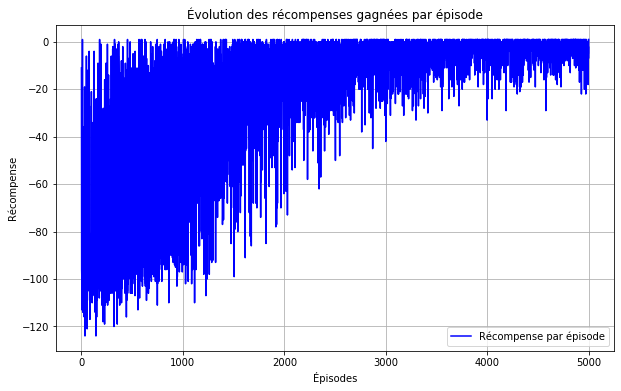

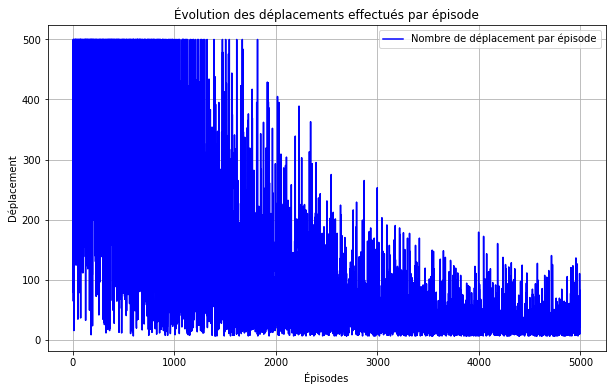

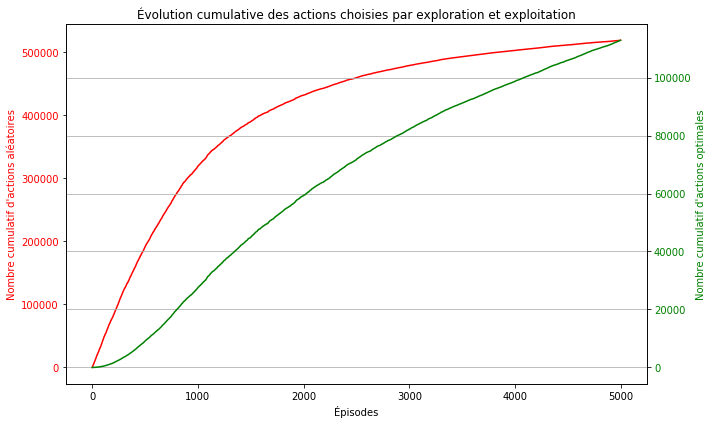

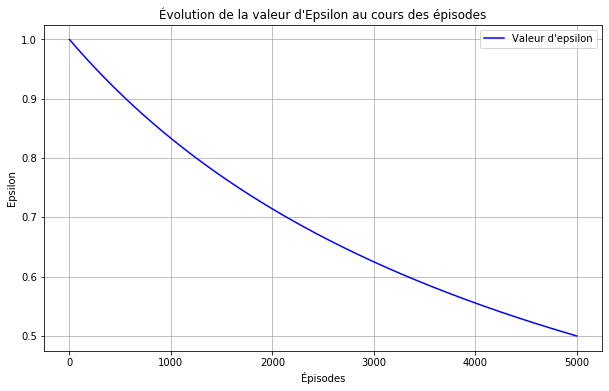

In [81]:
import matplotlib.pyplot as plt

# Graphique de l'évolution des récompenses
plt.figure(figsize=(10, 6))
plt.plot(range(num_episodes), rewards_per_episode, label="Récompense par épisode", color="blue")
plt.xlabel("Épisodes")
plt.ylabel("Récompense")
plt.title("Évolution des récompenses gagnées par épisode")
plt.legend()
plt.grid()
plt.show()

# Graphique de l'évolution des steps
plt.figure(figsize=(10, 6))
plt.plot(range(num_episodes), step_per_episode, label="Nombre de déplacement par épisode", color="blue")
plt.xlabel("Épisodes")
plt.ylabel("Déplacement")
plt.title("Évolution des déplacements effectués par épisode")
plt.legend()
plt.grid()
plt.show()

# Graphique avec deux axes y
fig, ax1 = plt.subplots(figsize=(10, 6))

# Courbe pour les actions aléatoires (exploration)
ax1.set_xlabel("Épisodes")
ax1.set_ylabel("Nombre cumulatif d'actions aléatoires", color="red")
ax1.plot(range(num_episodes), np.cumsum(exploration_counts["random"]), label="Exploration (aléatoire)", color="red")
ax1.tick_params(axis="y", labelcolor="red")

# Ajout d'un second axe y
ax2 = ax1.twinx()
ax2.set_ylabel("Nombre cumulatif d'actions optimales", color="green")
ax2.plot(range(num_episodes), np.cumsum(exploration_counts["q_table"]), label="Exploitation (optimale)", color="green")
ax2.tick_params(axis="y", labelcolor="green")

# Titre et légendes
plt.title("Évolution cumulative des actions choisies par exploration et exploitation")
fig.tight_layout()
plt.grid()
plt.show()

# Graphique de l'évolution de la valeur d'epsilon
plt.figure(figsize=(10, 6))
plt.plot(range(num_episodes), epsilon_values, label="Valeur d'epsilon", color="blue")
plt.xlabel("Épisodes")
plt.ylabel("Epsilon")
plt.title("Évolution de la valeur d'Epsilon au cours des épisodes")
plt.legend()
plt.grid()
plt.show()

### Modification des récompenses et du nombres de parties

In [39]:
position_initiale = [0, 0] 

def application_action(action, position, space):
    if action == 0:  # Haut
        nouvelle_position = [max(position[0] - 1, 0), position[1]]
    elif action == 1:  # Droite
        nouvelle_position = [position[0], min(position[1] + 1, len(space[0]) - 1)]
    elif action == 2:  # Bas
        nouvelle_position = [min(position[0] + 1, len(space) - 1), position[1]]
    elif action == 3:  # Gauche
        nouvelle_position = [position[0], max(position[1] - 1, 0)]
    else:
        nouvelle_position = position  # Si l'action est invalide, on ne bouge pas

    # Récupérer l'élément de la case où l'agent s'est déplacé
    reward = space[nouvelle_position[0]][nouvelle_position[1]]

    # Calculer la récompense et déterminer si la partie est finie
    if reward == -5:
        nouvelle_position = [0, 0] 
        fin = False
    elif reward == 0:
        fin = False
    elif reward == 50:
        fin = True


    return nouvelle_position, reward, fin


# Test de la fonction avec quelques exemples
position_actuelle = [0, 0]  # Position initiale de l'agent
action = 2  # L'agent va à droite (action 1)

nouvelle_position, reward, fin = application_action(action, position_actuelle, space)
print(f"Nouvelle position: {nouvelle_position}, Récompense: {reward}, Fin de partie: {fin}")

Nouvelle position: [0, 0], Récompense: -5.0, Fin de partie: False


In [47]:
import numpy as np
import random

# Configuration des paramètres
alpha = 0.81  # Taux d'apprentissage
gamma = 0.96  # Facteur de discount

# Initialisation de la table Q avec 16 états (cases) et 4 actions
q_table = np.zeros((16, 4))  # Dimensions : [cases x actions]

# Espace et récompenses
space = np.zeros((4, 4))
space[1, 0] = -5
space[1, 2] = -5
space[2, 3] = -5
space[3, 1] = -5
space[3, 3] = 50

# Fonction pour convertir une position (ligne, colonne) en un indice unique de 0 à 15
def position_to_index(position):
    return position[0] * 4 + position[1]

# Fonction pour choisir une action avec la stratégie epsilon-greedy
def choose_action(state_index, epsilon, q_table):
    if random.uniform(0, 1) < epsilon:
        # Exploration : choisir une action aléatoire
        action = random.choice([0, 1, 2, 3])  # Actions possibles : Haut, Droite, Bas, Gauche
        exploration = True
    else:
        # Exploitation : choisir l'action avec la plus grande valeur Q
        action = np.argmax(q_table[state_index, :])
        exploration = False
    return action, exploration

# Fonction d'une itération de Q-learning
def onestep(q_table, state, epsilon, exploration_counts):
    state_index = position_to_index(state)  # Convertir la position en indice
    action, exploration = choose_action(state_index, epsilon, q_table)  # Choisir une action

        # Mettre à jour les compteurs d'exploration/exploitation
    if exploration:
        exploration_counts["random"][-1] += 1
    else:
        exploration_counts["q_table"][-1] += 1

    # Appliquer l'action et obtenir la nouvelle position, la récompense et si la partie est finie
    nouvelle_position, reward, fin = application_action(action, state, space)
    nouvelle_position_index = position_to_index(nouvelle_position)

    # Mettre à jour la valeur Q
    old_value = q_table[state_index, action]
    next_max = np.max(q_table[nouvelle_position_index, :])
    q_table[state_index, action] = old_value + alpha * (reward + gamma * next_max - old_value)
    
    return q_table, nouvelle_position, fin,reward

# Entraînement de l'agent avec plusieurs épisodes
num_episodes = 500
epsilon_values = [] 
exploration_counts = {"random": [], "q_table": []}

cumulative_random = 0
cumulative_q_table = 0
rewards_per_episode=[]
step_per_episode=[]
for episode in range(num_episodes):
    epsilon = num_episodes / (num_episodes + episode)
    epsilon_values.append(epsilon)

    # Ajouter des compteurs pour cet épisode
    exploration_counts["random"].append(0)
    exploration_counts["q_table"].append(0)
    state = [0, 0]  # Position initiale
    fin = False
    step = 0
    max_step = 200
    total_reward=0
    while not fin and step < max_step:
        q_table, new_state, fin, reward = onestep(q_table, state, epsilon,exploration_counts)
        state = new_state  # Mise à jour de l'état 
        step += 1
        total_reward+=reward

        # Cumul des compteurs à chaque épisode
    cumulative_random += exploration_counts["random"][-1]
    cumulative_q_table += exploration_counts["q_table"][-1]

    rewards_per_episode.append(total_reward)
    step_per_episode.append(step)

# Visualisation de la table Q après l'entraînement
print("Table Q après l'entraînement :\n", q_table)

# Jouer une partie avec la politique optimale
def play_optimal_policy(q_table):
    state = [0, 0]  # Position initiale
    parcours = [state]  # Pour suivre le parcours
    fin = False
    while not fin:
        state_index = position_to_index(state)
        action = np.argmax(q_table[state_index, :])  # Choisir la meilleure action selon Q-table
        state, _, fin = application_action(action, state, space)
        parcours.append(state)
        if len(parcours) > 20:  # Prévenir les boucles infinies
            break
    return parcours

# Exécuter une partie avec la politique optimale
parcours_optimal = play_optimal_policy(q_table)
print("Parcours optimal :", parcours_optimal)

Table Q après l'entraînement :
 [[39.13788948 40.76863488 34.13788948 39.13788948]
 [40.76863488 39.13788948 42.467328   39.13788948]
 [39.13788948 37.57237391 34.13788948 40.76863488]
 [37.57237391 37.57237391 36.06947895 39.13788948]
 [ 0.          0.          0.          0.        ]
 [40.76863488 34.13788948 44.2368     34.13788948]
 [ 0.          0.          0.          0.        ]
 [37.57237391 36.06947895 34.13788948 34.13788948]
 [34.13788948 44.2368     40.76863488 42.467328  ]
 [42.467328   46.08       34.13788948 42.467328  ]
 [34.13788948 34.13788948 48.         44.2368    ]
 [ 0.          0.          0.          0.        ]
 [42.467328   34.13788948 40.76863488 40.76863488]
 [ 0.          0.          0.          0.        ]
 [46.08       50.         48.         34.13788948]
 [ 0.          0.          0.          0.        ]]
Parcours optimal : [[0, 0], [0, 1], [1, 1], [2, 1], [2, 2], [3, 2], [3, 3]]


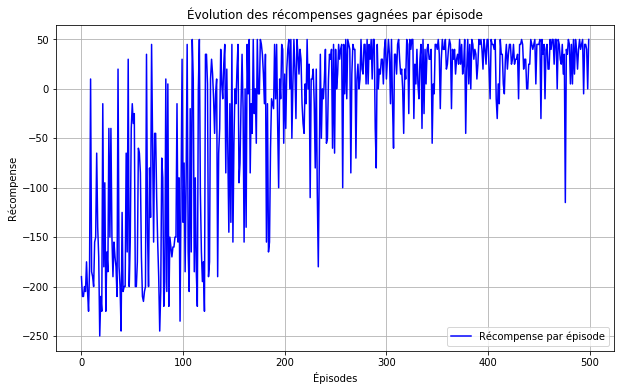

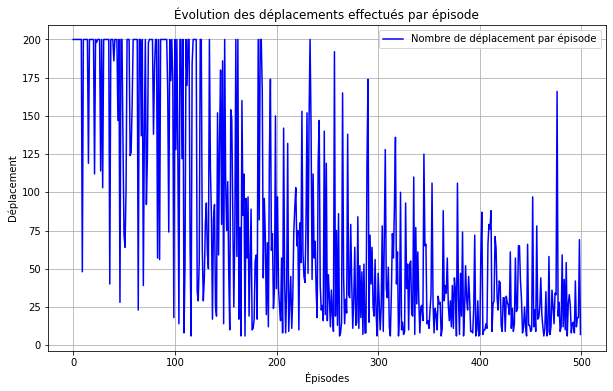

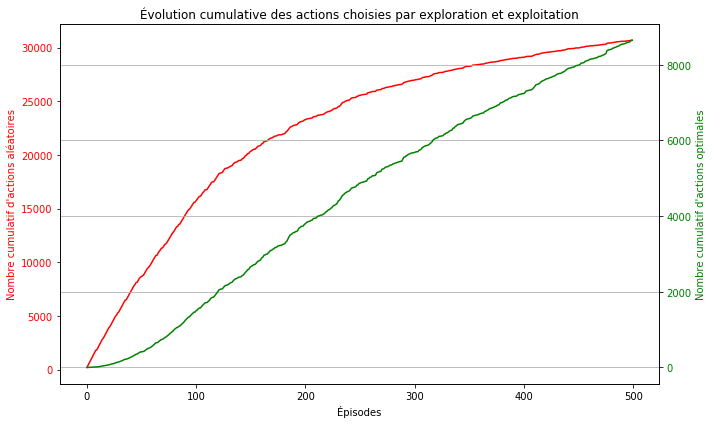

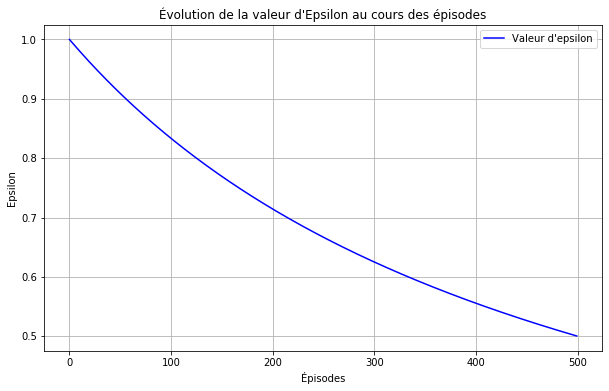

In [48]:
import matplotlib.pyplot as plt

# Graphique de l'évolution des récompenses
plt.figure(figsize=(10, 6))
plt.plot(range(num_episodes), rewards_per_episode, label="Récompense par épisode", color="blue")
plt.xlabel("Épisodes")
plt.ylabel("Récompense")
plt.title("Évolution des récompenses gagnées par épisode")
plt.legend()
plt.grid()
plt.show()

# Graphique de l'évolution des steps
plt.figure(figsize=(10, 6))
plt.plot(range(num_episodes), step_per_episode, label="Nombre de déplacement par épisode", color="blue")
plt.xlabel("Épisodes")
plt.ylabel("Déplacement")
plt.title("Évolution des déplacements effectués par épisode")
plt.legend()
plt.grid()
plt.show()

# Graphique avec deux axes y
fig, ax1 = plt.subplots(figsize=(10, 6))

# Courbe pour les actions aléatoires (exploration)
ax1.set_xlabel("Épisodes")
ax1.set_ylabel("Nombre cumulatif d'actions aléatoires", color="red")
ax1.plot(range(num_episodes), np.cumsum(exploration_counts["random"]), label="Exploration (aléatoire)", color="red")
ax1.tick_params(axis="y", labelcolor="red")

# Ajout d'un second axe y
ax2 = ax1.twinx()
ax2.set_ylabel("Nombre cumulatif d'actions optimales", color="green")
ax2.plot(range(num_episodes), np.cumsum(exploration_counts["q_table"]), label="Exploitation (optimale)", color="green")
ax2.tick_params(axis="y", labelcolor="green")

# Titre et légendes
plt.title("Évolution cumulative des actions choisies par exploration et exploitation")
fig.tight_layout()
plt.grid()
plt.show()

# Graphique de l'évolution de la valeur d'epsilon
plt.figure(figsize=(10, 6))
plt.plot(range(num_episodes), epsilon_values, label="Valeur d'epsilon", color="blue")
plt.xlabel("Épisodes")
plt.ylabel("Epsilon")
plt.title("Évolution de la valeur d'Epsilon au cours des épisodes")
plt.legend()
plt.grid()
plt.show()

In [46]:
print(range(num_episodes))
print(len(step_per_episode))

range(0, 500)
1500


## Deep Q-learning

In [49]:
# Espace et récompenses
space_deep = np.full((4, 4), 0)
space_deep[1, 0] = -5
space_deep[1, 2] = -5
space_deep[2, 3] = -5
space_deep[3, 1] = -5
space_deep[3, 3] = 50

print(space_deep)

[[ 0  0  0  0]
 [-5  0 -5  0]
 [ 0  0  0 -5]
 [ 0 -5  0 50]]


In [50]:
def position_to_vec_etat(position):
    index = position[0] * 4 + position[1]
    vec_etat = np.zeros(16)
    vec_etat[index] = 1
    return vec_etat


vec_etat = np.array(position_to_vec_etat([1,1]))

print(vec_etat)

[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [51]:
position_initiale = [0, 0] 


def application_action_deep(action, position, space):
    if action == 0:  # Haut
        nouvelle_position = [max(position[0] - 1, 0), position[1]]
    elif action == 1:  # Droite
        nouvelle_position = [position[0], min(position[1] + 1, len(space[0]) - 1)]
    elif action == 2:  # Bas
        nouvelle_position = [min(position[0] + 1, len(space) - 1), position[1]]
    elif action == 3:  # Gauche
        nouvelle_position = [position[0], max(position[1] - 1, 0)]
    else:
        nouvelle_position = position  # Si l'action est invalide, on ne bouge pas

    # Récupérer l'élément de la case où l'agent s'est déplacé
    reward = space[nouvelle_position[0]][nouvelle_position[1]]

    # Calculer la récompense et déterminer si la partie est finie
    if reward == -5:
        nouvelle_position = [0, 0] 
        fin = False
    elif reward == 0:
        fin = False
    elif reward == 50:
        fin = True


    return nouvelle_position, reward, fin


# Test de la fonction avec quelques exemples
position_actuelle = [0, 0]  # Position initiale de l'agent
action = 2  # L'agent va à droite (action 1)

nouvelle_position, reward, fin = application_action_deep(action, position_actuelle, space_deep)
print(f"Nouvelle position: {nouvelle_position}, Récompense: {reward}, Fin de partie: {fin}")

Nouvelle position: [0, 0], Récompense: -5, Fin de partie: False


In [54]:
import numpy as np
import random
import tensorflow as tf
from tensorflow import keras

# Configuration des paramètres
alpha = 0.001  # Taux d'apprentissage
gamma = 0.999  # Facteur de discount



# Création du modèle de réseau de neurones
model = keras.models.Sequential([
    keras.layers.Dense(8, activation='relu',input_shape = (16,)),
    keras.layers.Dense(4)
    ])
optimizer = keras.optimizers.Adam(learning_rate=alpha)
loss_fn=keras.losses.mean_squared_error

target = keras.models.clone_model(model) # Création d'une copie du modèle initial
target.set_weights(model.get_weights())

def position_to_vec_etat(position):
    index = position[0] * 4 + position[1]
    vec_etat = np.zeros(16)
    vec_etat[index] = 1
    return vec_etat

# Fonction pour choisir une action avec la stratégie epsilon-greedy
def choose_action_deep(state, epsilon, model):
    vec_etat = np.zeros((1,16))
    vec_etat[0,int(4*state[0] + state[1])] = 1

    if random.uniform(0, 1) < epsilon:
        # Exploration : choisir une action aléatoire
        action = random.choice([0, 1, 2, 3])
    else:
        # Exploitation : utiliser le modèle pour choisir l'action ayant la plus grande valeur Q
        sortie_Q = model.predict(np.array(vec_etat))
        action = np.argmax(sortie_Q[0])
    return action


def entrainenemnt():
    # Entraînement de l'agent avec plusieurs épisodes
    num_episodes = 500
    rewards_per_episode=[]
    for episode in range(num_episodes):

        epsilon = num_episodes / (num_episodes + episode)
        state = [0, 0]  # Position initiale
        fin = False
        step = 0
        max_step = 200
        total_reward=0
        while not fin and step < max_step:
            vec_etat = np.zeros((1,16))
            vec_etat[0,int(4*state[0] + state[1])] = 1
            
            action = choose_action_deep(state, epsilon, model)
            next_state, reward, fin = application_action_deep(action, state, space_deep)

            vec_etat_next = np.zeros((1,16))
            vec_etat_next[0,int(4*next_state[0] + next_state[1])] = 1
            next_Q = target.predict(np.array(vec_etat_next))
            next_Q_max=np.max(next_Q[0])

            target_val=reward+gamma*next_Q_max*(1-fin)

            total_reward+=reward
            

            with tf.GradientTape() as tape:
                predict = model(np.array(vec_etat)) #Ce que l'on pense obtenir
                mask = tf.one_hot(action,4)
                val_predict = tf.reduce_sum(predict*mask,axis = 1)
                loss = loss_fn(target_val,val_predict)
                
                
            gradients = tape.gradient(loss,model.trainable_variables)
            optimizer.apply_gradients(zip(gradients,model.trainable_variables))
            

            state = next_state  # Mise à jour de l'état
            step += 1


            if episode % 10 == 0 :
                target.set_weights(model.get_weights())
        rewards_per_episode.append(total_reward)
    return model, rewards_per_episode

# Jouer une partie avec la politique optimale
def play_optimal_policy(model):
    state = [0, 0]  # Position initiale
    parcours = [state]  # Pour suivre le parcours
    fin = False
    while not fin:
        vec_etat = np.zeros((1,16))
        vec_etat[0,int(4*state[0] + state[1])] = 1
        q_values = model.predict(np.array(vec_etat))
        action = np.argmax(q_values[0])  # Choisir la meilleure action selon le modèle
        state, reward, fin = application_action(action, state, space)
        parcours.append(state)
        if len(parcours) > 20:  # Prévenir les boucles infinies
            break
    return parcours


# Exécuter une partie avec la politique optimale
parcours_optimal = play_optimal_policy(entrainenemnt())
print("Parcours optimal avec DQN :", parcours_optimal)



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



AttributeError: 'tuple' object has no attribute 'predict'

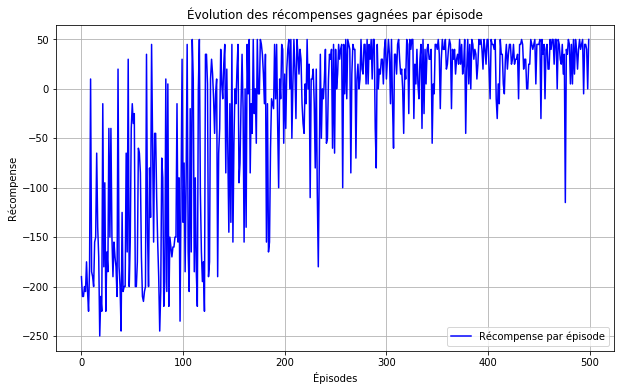

In [55]:
# Graphique de l'évolution des récompenses
plt.figure(figsize=(10, 6))
plt.plot(range(num_episodes), rewards_per_episode, label="Récompense par épisode", color="blue")
plt.xlabel("Épisodes")
plt.ylabel("Récompense")
plt.title("Évolution des récompenses gagnées par épisode")
plt.legend()
plt.grid()
plt.show()